# Group lasso

need to instal `pip install group-lasso` (https://pypi.org/project/group-lasso/) 

In [1]:
import glm_utils
import matplotlib.pyplot as plt
import numpy as np
import sklearn.linear_model
import sklearn.model_selection
from sklearn.metrics import r2_score
from group_lasso import GroupLasso

from demo_utils import get_data
plt.style.use('ncb.mplstyle')

# Generate toy data 
The stimulus `x` (`[time, stimuli]`) corresponds to four stimuli - for instance the distance, angle, velocity, and acceleration of flies.

The response `y` (`[time,]`) is produced by filtering each of the four stimuli in `x` with a filter (given by `filters`) and summing.

The filters are defined with the righmost value (delay 0) being closest to the response and the leftmost being furthest into the past (delay -50)

x: (100000, 4), y: (100000,), filters (50, 4)


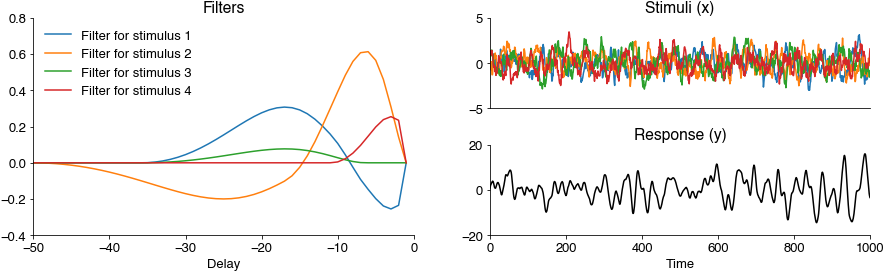

In [2]:
x, y, filters = get_data(npoints = 100_000)

nb_points, nb_stim = x.shape
filter_duration = filters.shape[0]
T = np.arange(-filter_duration, 0)

print(f"x: {x.shape}, y: {y.shape}, filters {filters.shape}")
plt.figure(figsize=[15,4])
plt.subplot(121)
plt.plot(T, filters)
plt.title('Filters')
plt.xlabel('Delay')
plt.legend([f'Filter for stimulus {f}' for f in range(1,5)])

plt.subplot(222)
plt.plot(x[:1000])
plt.title('Stimuli (x)')
plt.xticks(())

plt.subplot(224)
plt.plot(y[:1000], c='k')
plt.title('Response (y)')
plt.xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


In [3]:
nb_delays = 50
X, y_m = glm_utils.preprocessing.time_delay_embedding(x, y, window_size=nb_delays)
print(X.shape)


(99950, 200)


In [4]:
# construct the basis functions
B = glm_utils.bases.raised_cosine(0, 12, [0, 36], 16, nb_delays)
B_multi = glm_utils.bases.multifeature_basis(B, nb_features=nb_stim)
# intialize basis_projection object
basis_projection = glm_utils.preprocessing.BasisProjection(B_multi)
_, nb_bases = B.shape
T = np.arange(-nb_delays, 0)

print(f"Before basis projection: X {X.shape},  y {y_m.shape}.")
X_b = basis_projection.transform(X)
print(f"After basis projection: X {X_b.shape},  y {y_m.shape}.")

Before basis projection: X (99950, 200),  y (99950,).
After basis projection: X (99950, 48),  y (99950,).


In [5]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_b, y_m, test_size=0.2)
print(f"Shape of training set: {X_train.shape}, test set: {X_test.shape}")

Shape of training set: (79960, 48), test set: (19990, 48)


## Standard Lasso

Test score (r2): 1.00.


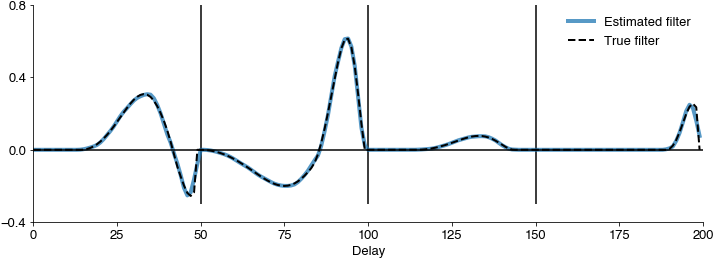

In [6]:
lr = sklearn.linear_model.LassoCV(max_iter=10_000)
lr.fit(X_train, y_train)
print(f"Test score (r2): {lr.score(X_test, y_test):1.2f}.")

filter_shape = basis_projection.inverse_transform(lr.coef_)

plt.figure(figsize=(12, 4))
plt.plot(filter_shape.T, linewidth=4, alpha=0.75, label='Estimated filter')
plt.gca().set_prop_cycle(None)
plt.plot(filters.T.ravel(), '--k', linewidth=2, label='True filter')
plt.axhline(c='k')
plt.vlines(np.arange(50, 4*50, 50), -0.3, 0.8)
plt.xlabel('Delay')
plt.yticks(np.arange(-0.4, 1.0, 0.4))
plt.legend()
plt.show()

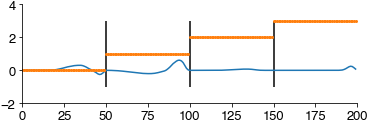

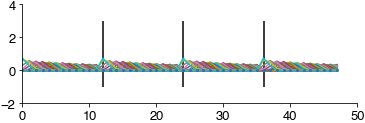

In [7]:
# make groups = stimuli
groups_time = np.floor(np.arange(len(filter_shape.T))/ nb_delays)
groups_bases = np.floor(np.arange(nb_stim * nb_bases)/ nb_delays)

plt.subplot(211)
plt.plot(filter_shape.T)
plt.plot(groups_time, '.')
plt.vlines(np.arange(50, 4*50, 50), -1, 3)
plt.show()


plt.subplot(211)
plt.plot(B_multi.T)
plt.plot(groups_bases, '.')
plt.vlines(np.arange(nb_bases, 4*nb_bases, nb_bases), -1, 3)
plt.show()



In [8]:
GroupLasso.LOG_LOSSES = True
num_regs = 20
group_regularisations = 1/np.logspace(-1.5, 1.5, num_regs)
weights = np.empty((num_regs, X_train.shape[1],))
coefs = np.empty((num_regs, X_train.shape[1],))
R2 = np.empty((num_regs,))

gl = GroupLasso(
    groups=groups_bases,
    group_reg=0,
    l1_reg=2,
    frobenius_lipschitz=True,
    scale_reg="inverse_group_size",
    subsampling_scheme=1,
    supress_warning=True,
    n_iter=1000,
    tol=1e-3,
    warm_start=True,
)

for i, group_reg in enumerate(group_regularisations[::-1]):
    gl.group_reg = group_reg
    gl.fit(X_train, y_train[:, np.newaxis])
    weights[-(i + 1)] = gl.sparsity_mask_.squeeze()
    coefs[-(i + 1)] = gl.coef_.squeeze()
    y_pred = gl.predict(X_test)
    R2[-(i + 1)] = r2_score(y_test, y_pred)
est_filters = basis_projection.inverse_transform(coefs)


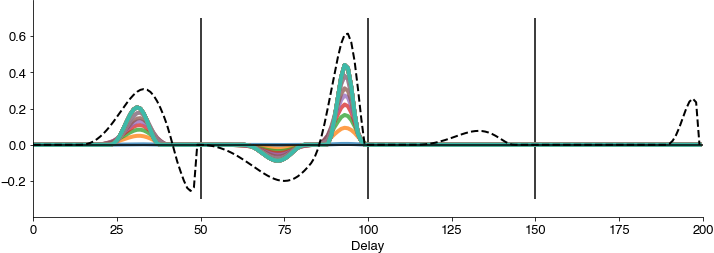

In [9]:
plt.figure(figsize=(12, 4))
plt.plot(est_filters.T, linewidth=4, alpha=0.75, label='Estimated filter')
plt.plot(filters.T.ravel(), '--k', linewidth=2, label='True filter')
plt.axhline(c='k')
plt.vlines(np.arange(50, 4*50, 50), -0.3, 0.7)
plt.xlabel('Delay')
plt.yticks(np.arange(-0.2, 0.8, 0.2))
plt.show()

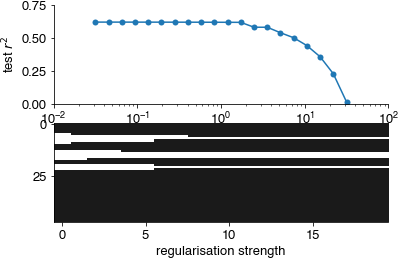

In [13]:
plt.subplot(211)
plt.plot(group_regularisations, R2, 'o-')
plt.xscale('log')
plt.ylabel('test $r^2$')
plt.xscale('log')

# Non-zero weights are grey, zero weights are black
plt.subplot(212)
plt.imshow(weights.T, cmap='Greys_r')
plt.clim(-.1, 1)
plt.xlabel('regularisation strength')
plt.show()

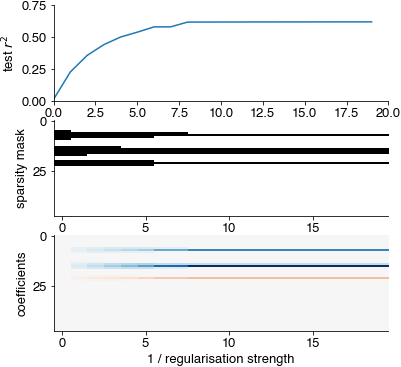

In [14]:
plt.figure(figsize=(6, 6))

plt.subplot(311)
plt.plot(R2)
plt.ylabel('test $r^2$')

plt.subplot(312)
plt.imshow(weights.T, cmap='Greys')
plt.ylabel('sparsity mask')

plt.subplot(313)
plt.imshow(coefs.T, cmap='RdBu')
plt.clim(-np.max(np.abs(coefs)), np.max(np.abs(coefs)))
plt.ylabel('coefficients')
plt.xlabel('1 / regularisation strength')
plt.show()
